In [84]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [85]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [86]:
## 평가모듈
import evaluation_module as evm

## Data

In [87]:
df_ori = pd.read_csv('data/data_prep.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

In [88]:
ML_res = pd.read_csv('data/result_ML.csv')
ML_res['time'] = pd.to_datetime(ML_res['time'])
ML_res = ML_res.set_index('time')

In [89]:
GRU_res = pd.read_csv('data/result_GRU.csv')
GRU_res['time'] = pd.to_datetime(GRU_res['time'])
GRU_res = GRU_res.set_index('time')

In [90]:
dataset = df_ori.copy()
dataset['hat_ML'] = ML_res['hat'].dropna()
dataset['hat_GRU'] = GRU_res['hat'].dropna()
dataset = dataset.dropna()

dataset['spread_ratio'] = dataset['spread']/dataset['vwap_near']

In [91]:
## 역사적 스프레드비율
temp = dataset.drop_duplicates(subset='epi_no', keep='last')
cri_min = temp['spread_ratio'].min()
cri_max = temp['spread_ratio'].max()

In [92]:
## Test index
test_split = df_ori[df_ori['epi_no'] > 8].index[0]
test_split

Timestamp('2019-12-27 12:00:00')

In [93]:
## 룰베이스 BM용 ## 5 ~ 9 에피소드 기준 최적 임계점
cri_ustd = dataset['spread_ratio'][:test_split].quantile(0.84)
cri_lstd = dataset['spread_ratio'][:test_split].quantile(0.43)

## 전략구현

* 전략 리스트  
  - ML: 스프레드매수매도 기회를 모두 활용하는 전략
  - ML_v2: 역사적 스프레드비율 외구간에서만 매수매도 기회를 활용하는 전략
  - Rule: 스프레드비율 1표준편차 외구간에서 매수매도하는 전략
* Bench Mark  
  - 당분기 선물 Buy&Hold

* ML전략 구현  
  - 예측 스프레드가 현재 스프레드보다 낮을 때는 스프레드 매도포지션
  - 예측 스프레드가 현재 스프레드보다 높을 때는 스프레드 매수포지션
  - 당분기물 만기시점에는 중립
  - pre_pos: 전기 포지션 => 전기 표지션을 통해서 현재 얻은 수익을 산출하기 위함

* GRU전략 구현  
  - ML전략과 동일하나 예측 모형을 RF -> GRU로 변경함

* Rule 전략 구현  
  - 스프레드 비율(Spread/당분기물가격) 상방 임계점 초과시 매도
  - 하방 임계점 미만시 매수
  - 당분기물 만기시점에는 중립
  - 스프레드 비율의 평균회귀 성향을 활용한 전략

* 주의사항: 거래비용은 고려하지 않음

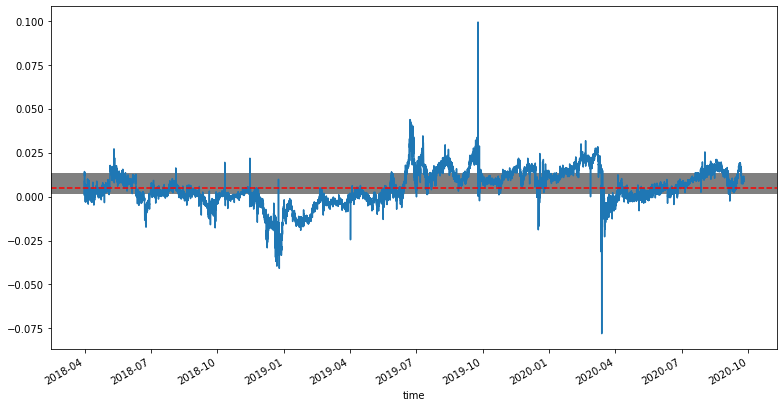

In [109]:
## Rule 전략 시각화
dataset['spread_ratio'].plot()
plt.axhline(dataset['spread_ratio'].mean(), color='r', linestyle='--')
plt.axhspan(cri_ustd, cri_lstd, facecolor='gray')

In [110]:
dataset['pre_pos_ML'] = 0
dataset['pre_pos_ML'][dataset['hat_ML'].shift(-1) > dataset['spread']] = 1
dataset['pre_pos_ML'][dataset['hat_ML'].shift(-1) < dataset['spread']] = -1
dataset['pre_pos_ML'][dataset['duetime'] == 0] = 0
dataset['pre_pos_ML'] = dataset['pre_pos_ML'].shift(1)

In [111]:
dataset['pre_pos_GRU'] = 0
dataset['pre_pos_GRU'][dataset['hat_GRU'].shift(-1) > dataset['spread']] = 1
dataset['pre_pos_GRU'][dataset['hat_GRU'].shift(-1) < dataset['spread']] = -1
dataset['pre_pos_GRU'][dataset['duetime'] == 0] = 0
dataset['pre_pos_GRU'] = dataset['pre_pos_GRU'].shift(1)

In [112]:
dataset['pre_pos_Rule'] = 0
dataset['pre_pos_Rule'][dataset['spread_ratio'] > cri_ustd] = -1
dataset['pre_pos_Rule'][dataset['spread_ratio'] < cri_lstd] = 1
dataset['pre_pos_Rule'][dataset['duetime'] == 0] = 0
dataset['pre_pos_Rule'] = dataset['pre_pos_Rule'].shift(1)

In [113]:
## 항상 매수포지션일 때의 수익률
## 스프레드차익/(매수증거금+매도증거금)
lev = 1 ##레버리지
dataset['rets'] = ((dataset['spread'] - dataset['spread'].shift(1))/
                   ((dataset['vwap_near']+dataset['vwap_longer'])*(1/lev)).shift(1))

In [114]:
## 예측모형을 활용한 양측 매매 전략
dataset['ML'] = dataset['rets'] * dataset['pre_pos_ML']

## 역사적 스프레드 비율을 임계점으로 활용하는 전략
dataset['ML_v2'] = dataset['ML'].copy()
dataset['ML_v2'][(dataset['spread_ratio'].shift(1) <= cri_max)&(dataset['spread_ratio'].shift(1) >= cri_min)] = 0

## GRU 예측모형을 활용한 양측 매매 전략
dataset['GRU'] = dataset['rets'] * dataset['pre_pos_GRU']

## Rule Spread 비율이 2표준편차를 초과할때만 매도매수
dataset['Rule'] = dataset['rets'] * dataset['pre_pos_Rule']

## BM1: 당분기물 Buy&Hold 롤오버는 고려하지 않음
dataset['BM1'] = dataset['vwap_near'].pct_change()

## 전략 평가

In [115]:
df_rets = dataset[['ML', 'ML_v2', 'GRU', 'Rule', 'BM1']].dropna()

### 평가 요약

In [116]:
report = evm.get_report2(df_rets, term='bit')
print('전체기간 성능평가')
report
## 분석 초기 과도한 스프레드가 높은 Return으로 나타남
## Trainset이 포함되었으므로 모델 적합을 파악할 목적으로 만 활용

전체기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML,0.2481,0.0964,2.5736,-0.1226,0.5054
ML_v2,0.0897,0.0540,1.6606,-0.0781,0.9690
GRU,1.6115,0.0949,16.9832,-0.0075,0.5897
Rule,0.4830,0.0803,6.0125,-0.0376,0.7379
BM1,0.1625,0.6727,0.2415,-0.7175,0.5133


In [117]:
report_l3 = evm.get_report2(df_rets[test_split:], term='bit')
print('최근 3분기(Test기간) 성능평가')
report_l3

최근 3분기(Test기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
GRU,1.4010,0.0931,15.0530,-0.0075,0.5927
Rule,0.5149,0.0758,6.7964,-0.0131,0.7634
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


### 자산가치 추이

<AxesSubplot:xlabel='time'>

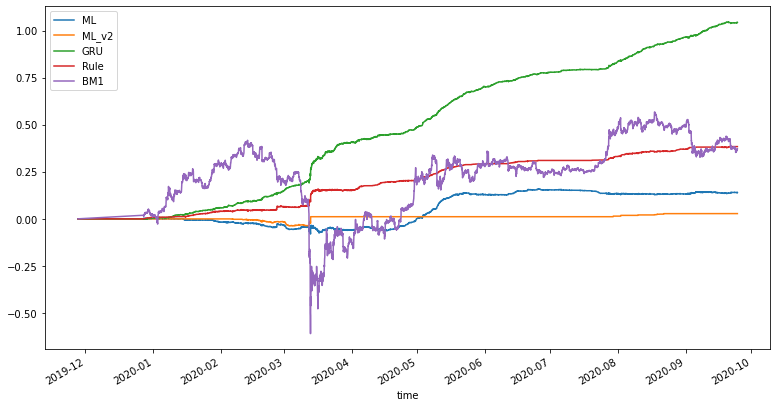

In [118]:
df_value_L3 = evm.get_df_val(df_rets[test_split:])
## Test기간
np.log(df_value_L3).plot()

### MDD

In [119]:
df_dd = evm.get_dd(df_value_L3)

<AxesSubplot:xlabel='time'>

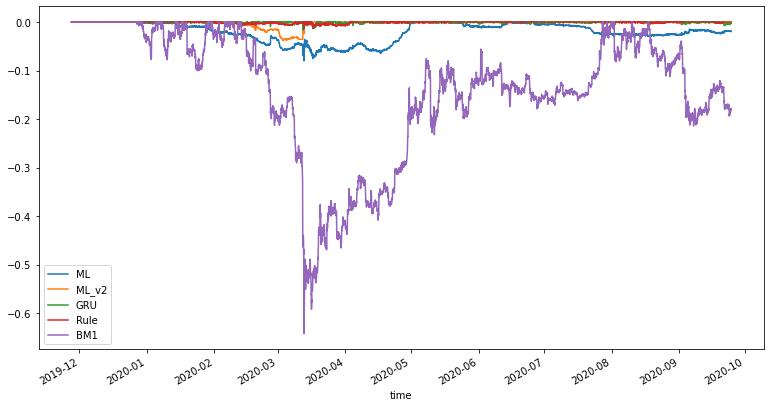

In [120]:
df_dd.plot()

<AxesSubplot:xlabel='time'>

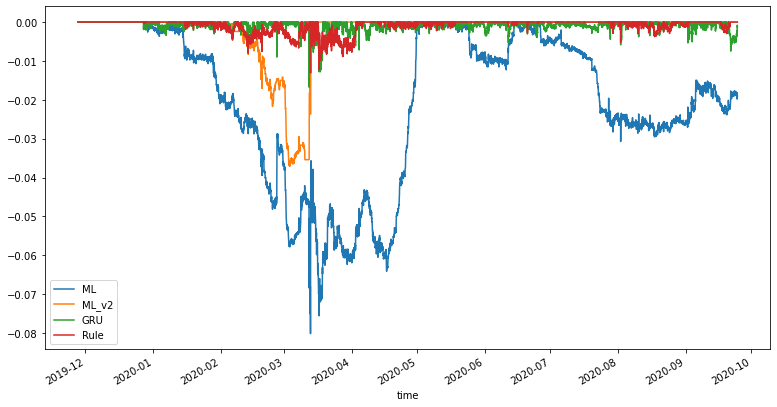

In [131]:
## BM 제외
df_dd[['ML', 'ML_v2', 'GRU', 'Rule']].plot()

### Turn Over

In [123]:
temp = dataset[test_split:].copy()

TO_ML = len(temp[(temp['pre_pos_ML'].shift() != temp['pre_pos_ML'])])
TO_GRU = len(temp[(temp['pre_pos_GRU'].shift() != temp['pre_pos_GRU'])])
TO_Rule = len(temp[(temp['pre_pos_Rule'].shift() != temp['pre_pos_Rule'])])

In [124]:
print(f"Test기간 {len(temp)}틱 중")
print(f"ML: {TO_ML}회")
print(f"GRU: {TO_GRU}회")
print(f"Rule: {TO_Rule}회")
print("포지션 변경발생")

Test기간 6529틱 중
ML: 725회
GRU: 2501회
Rule: 631회
포지션 변경발생


## 결론

In [125]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
GRU,1.4010,0.0931,15.0530,-0.0075,0.5927
Rule,0.5149,0.0758,6.7964,-0.0131,0.7634
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


### 중수익 저위험 만족 전략

  - 저위험 중수익을 어떻게 정의할 수 있을까?
  - 저위험 중수익을 Return 15%, Volatility 10%로 정의한다면, Test기간에 대해 중수익 저위험을 만족하는 전략은 ML, GRU, Rule 전략임

### BM 선정

* BM1
  - BM1은 당분기물 B&H 전략으로 상당한 변동성(73%)에 노출되어 있는 것을 알 수 있음
  - 또한, MDD가 64%수준으로 실제 투자에 적용한다면 상당한 스트레스에 노출될 수 있음

### 전략별 평가

* 예측기반 스프레드 매수매도전략; ML 
  - 수익률, 변동성 각각 18.7%, 9.4% 으로 준수한 수익률과 BM1 대비 안정적인 변동성을 기록함
  - Sharpe 역시 1.99 수준으로 준수함
  - MDD는 8.0% 수준임
  - 다만 전기간대비 Test기간(최근 3분기)의 Sharpe 급격히 떨어지는 것으로 보아 모형의 과적합을 의심할 수 있음 2.57 -> 1.99

* 역사적 스프레드에서 거래하지 않는 전략; M_v2  
  - 역사적 스프레드를 당분기물 결재일 스프레드의 평균값으로 정의함
  - 수익률, 변동성 각각 3.7%, 5.3% 으로 ML 대비 낮은 수익률과 낮은 변동성을 기록함
  - 역사적 스프레드 내에서 거래불가 규칙이 변동성을 낮추는 역할을 함
  - 하지만 유의미한 투자기회를 다수 상실함으로썬 수익률 하락으로 이어짐
  - 그 결과 Sharpe가 0.71 수준으로 떨어짐

* 예측기반 스프레드 매수매도전략; GRU
  - 수익률, 변동성 각각 140.1%, 9.3% 으로 높은 수익률과 BM1 대비 안정적인 변동성을 기록함
  - Sharpe 역시 15.05 수준으로 준수함
  - MDD는 0.7% 수준임
  - 과도하게 높은 모형 성능에 대한 검증이 필요함...

* Spread ratio 임계점 외구간 스프레드 매수매도 전략; Rule
  - 수익률, 변동성 각각 54.5%, 7.6% 으로 높은 수익률과 BM1 대비 안정적인 변동성을 기록함
  - Sharpe 역시 6.24 수준으로 가장 준수함
  - MDD는 1.3% 수준임
  - 전체기간대비 Test기간의 Sharpe 하락도 관찰되지 않음 5.38 -> 6.24
  - 단순한 임계점에서 매매하는 전략임에도 매우 비대칭적 성과를 보임 => 크립토 시장의 단기적 비효율성의 근거일 수 있음

### 총평

In [127]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
GRU,1.4010,0.0931,15.0530,-0.0075,0.5927
Rule,0.5149,0.0758,6.7964,-0.0131,0.7634
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126


* 수익률: GRU > Rule > BM1 > ML > ML_v2
* 변동성(-): ML_v2 > Rule > GRU > ML > BM1
* Sharpe: GRU > Rule > ML > ML_v2 > BM1
* MDD: GRU > Rule > ML_v2 > ML > BM1

* 변동성을 제외한 모든 평가지표에서 GRU, Rule 전략이 우수한 성과를 보임
* 중수익 저위험(Return 15%, Volatility 10%) 관점에 부합하는 전략은 GRU, ML, Rule 전략임
* 하지만 모든 평가기준에서 GRU, Rule 전략의 성과가 우수함

* Test기간에 대한 적용(future peeking, 과적합 방지)임에도 불구하고 GRU, Rule 전략의 과도한 비대칭적 성과가 나타나는 것이 놀라움..
* Spread_Ratio의 평균회귀 성향이 매우 강한 동시에, 순간적으로 Spread가 과도하게 벌어지는 투자기회가 다수 존재함을 알 수 있음

* 주의사항: 매매비용을 전혀 고려하지 않은 분석임